In [1]:
import numpy as np
# 假设有 3 台机器和 3 个操作
m = 3 # 机器数量
N = 2 # 表示机器的二进制 (0, 1)
n = 3 # 操作数量
l = 1  # 用于表示 C_max 的二进制位数

# 处理时间矩阵 (例如)
p = np.array([[1, 2, 3],[2, 3, 1],[3, 1, 2]])

b = np.array([[0, 0],[1, 0] ,[0, 1]])
# 非法数组(用于表示机器数)(1, 1)
bw = np.array([[1, 1]])
# 常数
K1 = 100
P = 30
# print(len(bw))
# 量子比特数量
num_qubits = n * N + l

In [2]:
def append_multi_rzz_term(qc, qubits, gamma): 
    """
    构建一个类RZZ门，n-1个控制位，1个目标位，进行旋转操作。
    参数:
    control_qubits: List[int]，控制量子比特的索引
    target_qubit: int，目标量子比特的索引
    """
    if len(qubits)==1:
        qc.rz(gamma, qubits[0])
    else:
        control_qubits = qubits[:N-1]
       
        target_qubit = qubits[N-1:]
       
        n_controls = len(control_qubits)
        if n_controls == 1:     
            qc.cx(control_qubits[0],target_qubit[0])
        else:
            qc.mcx(control_qubits, target_qubit[0])
        qc.rz(gamma, target_qubit[0])
        if n_controls == 1:
            qc.cx(control_qubits[0], target_qubit[0])
        else:
            qc.mcx(control_qubits, target_qubit[0])

In [3]:
def append__zz_term( qc, qubit1, qubit2, gamma):
    qc.cx(qubit1, qubit2)
    qc.rz(gamma, qubit2)
    qc.cx(qubit1, qubit2)

def append__z_term(qc, qubit, gamma):
    qc.rz(gamma, qubit)
def append__mixer_term(qc, qubit, beta):
    qc.rx(2 * beta, qubit)

In [4]:
def get_cost_circuit1(gamma, qc):
    for h in range(l):
        coef = - 2**h
        append__z_term(qc, N * n + h, coef * gamma)
    return qc

\begin{align}K_{1} \sum_{j\in W} \sum_{i=0}^{n}\prod_{k=0}^{N}\left(\frac{1}2+\left(\frac{1}2-b_{j k}\right)Z_{ik}\right)\end{align}

In [5]:
import itertools
def get_cost_circuit2(gamma, qc):
    # print(len(bw))
    if len(bw) == 0:
        return qc
    all_combinations = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(1, N + 1))))
    for j in range(len(bw)):
        for i in range(n):
            constant = 1 / (2 ** N)  # 系数 1/2^N  
            for qubit_indices in all_combinations: # 遍历各种组合
                qubits_index = np.array([], dtype=int)
                # 根据组合项生成子项的常数和qubit索引
                for k in range(N):
                    constant *= (1 - 2 * bw[j, k]) if k in qubit_indices else 1
                    if k in qubit_indices:
                        qubits_index = np.append(qubits_index, i * N + k)
                # print("qubits_index", qubits_index)
                append_multi_rzz_term(qc, qubits_index, 2 * K1 * constant * gamma)
    return qc


In [6]:
# from qiskit import Aer, QuantumCircuit, execute
# gamma= 1
# qc = QuantumCircuit(num_qubits, num_qubits)
# # qc.h(range(num_qubits))
# # print(qc)
# get_cost_circuit2(gamma, qc)
# print(qc)
# qc.decompose().draw('mpl')

\begin{align}\sum_{j=0}^{m-1}\sum_{i=0}^{n-1} \sum_{i^{\prime}=0}^{n-1}\left(\prod_{k=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i k}\right)\right) p_{i j}\left(\prod_{k^{\prime}=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i^{\prime} k^{\prime}}\right)\right) p_{i^{\prime} j}\end{align}
\begin{align}-2 \sum_{j=0}^{m-1} \sum_{i=0}^{n-1} \sum_{h=0}^{l-1} \left(\prod_{k=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i k}\right)\right) p_{i j} \cdot 2^{h-1}\left(1-Z_h\right)\end{align}
\begin{align}\sum_{j=0}^{m-1}\sum_{h=0}^{l-1} \sum_{h^{\prime}=0}^{l-1} 2^{h-1} 2^{h^{\prime}-1}\left(1-Z_h-Z_{h^{\prime}}+Z_h Z_{h^{\prime}}\right)\end{align}

In [7]:
# import itertools
from collections import Counter

def get_cost_circuit3(gamma, qc):
    for j in range(len(b)):
        # 对应12, 13, 23, 45, 46, 56
        for i in range(n): # 自身内部相乘，对应12, 13, 23, 45, 46, 56
            all_combinations_1 = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(1, N + 1))))
            # 获取 all_combinations_1 中任意两项的所有组合
            all_two_combinations = list(itertools.combinations(all_combinations_1, 2))
            for qubit_indices in all_two_combinations: # 遍历各种组合
                # print("qubit_indices", qubit_indices)
                # sub_constant = constant
                qubits_index = np.array([], dtype=int)
                constant = 1
                # 将组合对中的每个元素（每个元素本身也是一个组合）放入数组
                for combo in qubit_indices: # qubit_indices: ((0,), (1,)) 
                    for k in combo: # combo: (0,)
                        constant = constant * (1 - 2 * b[j, k])
                        qubits_index = np.append(qubits_index, i * N + k)
                    # 将组合项中的所有元素添加到 qubits_index 中
                # 剔除出现偶次数的项，奇次数的项保留一个

                count = Counter(qubits_index)
                # 仅保留出现次数为奇数的元素一次
                qubits_index = [x for x in count if count[x] % 2 != 0]
                # print("qubits_index", qubits_index)
                constant = 1/(2 ** (2 * N)) * constant * p[i, j] * p[i, j]
                append_multi_rzz_term(qc,qubits_index , 2 * P * constant * gamma)

        # 2，对应14, 15, 16, 24, 25, 26, 34, 35, 36
        all_combinations_1 = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(1, N + 1))))  
        all_combinations_2 = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(1, N + 1))))  
        for i1 in range(n - 1): # 自身内部相乘，对应14, 15, 16, 24, 25, 26, 34, 35, 36
            for i2 in range(i1 + 1, n): # 自身内部相乘，对应23, 45, 46, 56
                for qubit_indices_1 in all_combinations_1:
                    # print("qubit_indices1", qubit_indices_1)
                    for qubit_indices_2 in all_combinations_2:
                        # print("qubit_indices2", qubit_indices_2)
                        qubits_index = np.array([], dtype=int)
                        constant = 1
                        for k1 in qubit_indices_1: # qubit_indices: ((0,), (1,))
                            constant = constant * (1 - 2 * b[j, k1])
                            qubits_index = np.append(qubits_index, i1 * N + k1)
                        for k2 in qubit_indices_2: # qubit_indices: ((0,), (1,))
                            constant = constant * (1 - 2 * b[j, k2])
                            qubits_index = np.append(qubits_index, i2 * N + k2)
                        constant = 1/(2 ** (2 * N)) * constant * p[i1, j] * p[i2, j]
                        # print("qubits_index", qubits_index)
                        append_multi_rzz_term(qc,qubits_index ,2 * P * constant * gamma)


        # 对应01,02,03,74,75,76
        all_combinations = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(1, N + 1))))
        for i1 in range(n): # 取常数 1 固定一个为 p[i_1, j]
            for i2 in range(n): # 取 Z 的下标 Z_i2k
                for qubit_indices in all_combinations: # 取 排列组合
                    qubits_index = np.array([], dtype=int)
                    constant = 1
                    for k in qubit_indices:
                        constant = constant * (1 - 2 * b[j, k])
                        qubits_index = np.append(qubits_index, i2 * N + k)
                    constant = 1/(2 ** (2 * N)) * constant * p[i1, j] * p[i2, j]
                    # print("qubits_index", qubits_index)
                    append_multi_rzz_term(qc,qubits_index ,2 * P * constant * gamma)
        
        
        all_combinations = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(1, N + 1))))
        for i in range(n):
            constant = 1 / (2 ** N) * p[i, j]# 系数 
            constant1 = constant
            for qubit_indices in all_combinations: # 遍历各种组合
                qubits_index = np.array([], dtype=int)
                # 根据组合项生成子项的常数和qubit索引
                for k in range(N):
                    constant1 *= (1 - 2 * b[j, k]) if k in qubit_indices else 1
                    if k in qubit_indices:
                        qubits_index = np.append(qubits_index, i * N + k)
                # print("qubits_index", qubits_index)
                constant1 = constant1 * (2**(l - 1)) * (-2)
                append_multi_rzz_term(qc, qubits_index, 2 * P * constant1 * gamma)
            constant2 = constant
            for h in range(l):
                for qubit_indices in all_combinations: # 遍历各种组合
                    qubits_index = np.array([], dtype=int)
                    # 根据组合项生成子项的常数和qubit索引
                    for k in range(N):
                        constant2 *= (1 - 2 * b[j, k]) if k in qubit_indices else 1
                        if k in qubit_indices:
                            qubits_index = np.append(qubits_index, i * N + k)
                    # print("qubits_index", qubits_index)
                    qubits_index = np.append(qubits_index, n * N + h)
                    constant2 = constant2 * (2**(h-1)) * (-2)
                    append_multi_rzz_term(qc, qubits_index, 2 * P * constant2 * gamma)
        
        for h1 in range(l):  # 遍历 h 的范围
            for h2 in range(l):  # 遍历 h' 的范围
                coef = 2 ** (h1 - 1) * 2 ** (h2 - 1)  # 计算系数权重

                # -Z_h1 项
                append__z_term(qc, n * N + h1, 2 * P * coef * gamma)

                # -Z_h2 项
                append__z_term(qc, n * N + h2, 2 * P * coef * gamma)

                # Z_h1 Z_h2 项
                if h1 != h2:  # 避免重复
                    append__zz_term(qc, n * N + h1, n * N + h2, 2 * P * coef * gamma)
        
                    
                

In [8]:
# from qiskit import Aer, QuantumCircuit, execute
# gamma= 1
# qc = QuantumCircuit(num_qubits, num_qubits)
# get_cost_circuit3(gamma, qc)
# print(qc)
# qc.decompose().draw('mpl')

In [9]:
# from qiskit import Aer, QuantumCircuit, execute
# gamma= 1
# qc = QuantumCircuit(num_qubits, num_qubits)
# # qc.h(range(num_qubits))
# # print(qc)
# get_cost_circuit4(gamma, qc)
# # print(qc)
# # qc.decompose().draw('mpl')

In [10]:
def get_mixer_circuit(beta, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for i in range(num_qubits):
        append__mixer_term(qc, i, beta)
    return qc

In [11]:
def invert_counts(s):
    return s[::-1]

In [12]:
from qiskit import Aer, QuantumCircuit, execute
# 定义成本函数
def cost_function(params):
    beta, gamma = params[:len(params)//2], params[len(params)//2:]
    num_qubits = n * N + l
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(range(num_qubits))
    # print(qc)

    length  = len(params)
    for i in range(int(length/2)):

        get_cost_circuit1(gamma[i], qc)
        get_cost_circuit2(gamma[i], qc)
        get_cost_circuit3(gamma[i], qc)
        get_mixer_circuit(beta[i], qc)
    # 模拟电路
    # 添加测量指令
    qc.measure(range(num_qubits), range(num_qubits))
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, seed_simulator=10, shots=10000).result()
    counts = result.get_counts(qc)
    # 计算期望值
    expectation = 0
    for bitstring, count in counts.items():
        bitstring = invert_counts(bitstring)
        prob = count / 10000
        z_h = np.array([int(bit) for bit in bitstring[(n*N):]])
        s_ik = np.array([int(bit) for bit in bitstring[:(n*N)]]).reshape(n, N)
        E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
        E2 = 0
        for j in range(len(bw)):
            for i in range (n):
                constant = 1
                for k in range (N):
                    constant = constant*(1-(s_ik[i,k]-bw[j,k])**2)
                E2 += constant
        E2 = K1 * E2
        E3 = 0
        for j in range(m):
            constant1 = 0
            for i in range(n):
                constant2 = 1
                for k in range(N):
                    constant2 = constant2*(1-(s_ik[i,k]-b[j,k])**2)
                constant1 += p[i,j]*constant2
            constant3 = 0
            for h in range(l):
                constant3 += 2 ** h * z_h[h]
            constant = max(0, constant1 - constant3)
            E3 += P * (constant)**2
        
        # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])
        
        E =  E1 + E2 + E3
        
        expectation += E * prob

    return expectation, counts

In [13]:
from qiskit_algorithms.optimizers import COBYLA

# 优化 QAOA 参数
def optimize_qaoa(params):
    def objective(params):
        expectation, _ = cost_function(params)

        return expectation

    optimizer = COBYLA(rhobeg = 1.5, tol = 1e-8)
    # params = np.random.rand(2 * p_max) * 2 * np.pi
    result = optimizer.minimize(fun=objective, x0=params)

    return result

In [ ]:
import time

# 运行优化
startTime = time.time()
ansatz_final = object()
init_point = np.array([])
counts = {}
min_energy = 0
final_result = object()
for p1 in range(1, 4):
    min_energy = 10000
    for k in range(50):
        print('第：', p1, '层', ' ', '第', k, '个参数')
        init_point_temp = init_point
        beta_p = np.random.uniform(0, np.pi)
        gamma_p = np.random.uniform(0,  2 * np.pi)
        if k >0:
            init_point_temp = np.delete(init_point_temp, 2 * p1 - 1)
            init_point_temp = np.delete(init_point_temp, p1 - 1)
        init_point_temp = np.insert(init_point_temp, p1 - 1, beta_p)
        init_point_temp = np.insert(init_point_temp, 2 * p1 - 1, gamma_p)
        result = optimize_qaoa(init_point_temp)

        # print(result.x)
        optimal_params = result.x

        # 计算最终的能量
        energy, counts_temp = cost_function(result.x)
        if min_energy > energy:
            min_energy = energy
            init_point = optimal_params
            counts = counts_temp
            final_result = result
endTime = time.time()

第： 1 层   第 0 个参数
第： 1 层   第 1 个参数
第： 1 层   第 2 个参数


优化时间： 289.20778012275696
Optimal parameters: [4.05163472 1.90782068 0.21428758 1.99510431 2.35572587 3.55706474]
Optimal value: 232.72440000000003
Final expectation value: 232.72440000000003
Final measurement counts: {'0001101': 1009, '0001011': 854, '1100101': 637, '0111001': 454, '0011111': 377, '1011111': 366, '1001111': 315, '0110001': 232, '0011001': 230, '1000101': 229, '0111111': 199, '1011001': 197, '1000111': 188, '1001001': 184, '0101111': 181, '1110011': 180, '1000011': 177, '0000011': 173, '0011101': 146, '0010011': 132, '1101011': 123, '0111101': 120, '0110011': 119, '1101001': 115, '1101101': 114, '1111111': 102, '1101000': 99, '0001111': 97, '1100011': 89, '1011011': 83, '1100111': 72, '0000111': 69, '0100101': 69, '0011110': 64, '0101011': 63, '1001110': 62, '0001100': 62, '0000101': 62, '1001000': 61, '1110110': 59, '0101101': 56, '1011101': 54, '1010101': 54, '0010001': 53, '1111011': 53, '0000110': 52, '0100100': 50, '0101001': 50, '0011011': 49, '0011100': 48, '0010

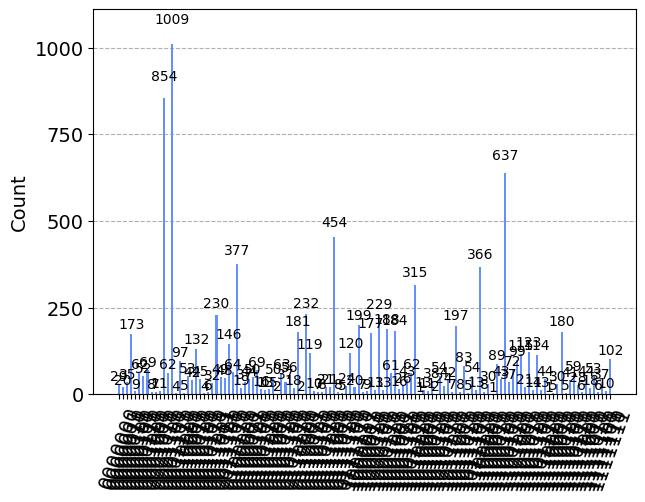

In [73]:
from qiskit.visualization import plot_histogram

# 输出结果
print("优化时间：", endTime - startTime)
print("Optimal parameters:", final_result.x)
print("Optimal value:", final_result.fun)
# 使用最优参数运行量子电路并输出测量结果
final_expectation, final_counts = cost_function(final_result.x)
sorted_dict = {item[0][::-1]: item[1] for item in sorted(final_counts.items(), key=lambda item: item[1], reverse=True)}
print("Final expectation value:", final_expectation)
print("Final measurement counts:", sorted_dict)
plot_histogram(sorted_dict)

In [74]:
expectation = 0
bitstring = "0001101"
z_h = np.array([int(bit) for bit in bitstring[(n*N):]])
s_ik = np.array([int(bit) for bit in bitstring[:(n*N)]]).reshape(n, N)
E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
E2 = 0
for j in range(len(bw)):
    for i in range (n):
        constant = 1
        for k in range (N):
            constant = constant*(1-(s_ik[i,k]-bw[j,k])**2)
        E2 += constant
E2 = K1 * E2
E3 = 0
for j in range(m):
    constant1 = 0
    # print("机器：", j)
    for i in range(n):
        constant2 = 1
        for k in range(N):
            constant2 = constant2*(1-(s_ik[i,k]-b[j,k])**2)
        # print("constant2:", constant2)
        # print("p[i,j]:", p[i,j])
        constant1 += p[i,j]*constant2
    # print("constant1:", constant1)
    constant3 = 0
    for h in range(l):
        constant3 += 2 ** h * z_h[h]
    # print("constant3:", constant3)
    constant = max(0, constant1 - constant3)
    E3 += (constant)**2
        
        # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])
        
E =  E1 + K1 * E2 + P * E3
print(E1)
print(E2)
print(E3)
# print(e1)
# print(e2)

1
0
0
